In [29]:
import json
import cv2
import PIL
import pdb
import torch
import copy
from PIL import Image
from utils.demo_utils import assert_region_width, assert_region_placement
from IPython import display
import numpy as np
from E2EVE.main_functions import instantiate_from_config
from E2EVE.data.E2EVE_data import DemoData, E2EVE_dataset_base
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


	 autosetting source_image_size -> 256
	 autosetting driver_image_size -> 64
	 autosetting image_scale_transform -> 1
driver image for example 0


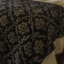

masked source image for example 0


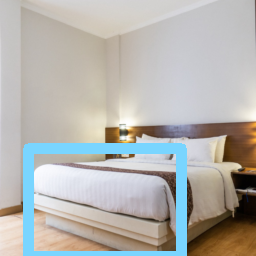

driver image for example 1


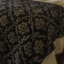

masked source image for example 1


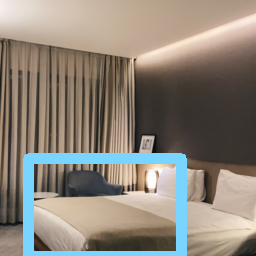

driver image for example 2


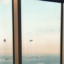

masked source image for example 2


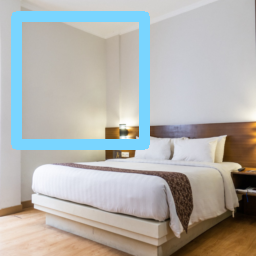

driver image for example 3


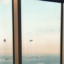

masked source image for example 3


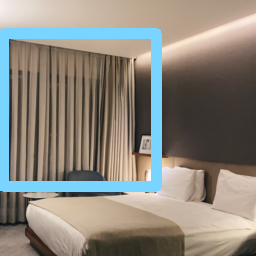

In [33]:
# ======================================
# load and view the input data, and mark the edit regions on the source images (this demo is for block edits)
# ======================================

# make sure the meta data is downloaded (see README)
examples = [
    {
    'source_image_path':"../E2EVE_meta/LSUN_meta/demo_images/source_1.jpg",
    'driver_image_path':"../E2EVE_meta/LSUN_meta/demo_images/driver_1.jpg",
    'edit_region_width':0.6,
    'edit_region_centre':(105,225)
},
    {
    'source_image_path':"../E2EVE_meta/LSUN_meta/demo_images/source_2.jpg",
    'driver_image_path':"../E2EVE_meta/LSUN_meta/demo_images/driver_1.jpg",
    'edit_region_width':0.6,
    'edit_region_centre':(105,235)
},
    {
    'source_image_path':"../E2EVE_meta/LSUN_meta/demo_images/source_1.jpg",
    'driver_image_path':"../E2EVE_meta/LSUN_meta/demo_images/driver_2.jpg",
    'edit_region_width':0.5,
    'edit_region_centre':(80,80)
},
    {
    'source_image_path':"../E2EVE_meta/LSUN_meta/demo_images/source_2.jpg",
    'driver_image_path':"../E2EVE_meta/LSUN_meta/demo_images/driver_2.jpg",
    'edit_region_width':0.6,
    'edit_region_centre':(80,110)},]

# load the data loader object which has a function needed for turning the edit region parameters into coordinates
data_loader = E2EVE_dataset_base(source_image_size=256,driver_image_size=64,image_scale_transform=1)


for ind in range(len(examples)):
    example = examples[ind]
    
    # read the images
    with open(example['source_image_path'], "rb") as fid:
        source_image = PIL.Image.open(fid)
        if source_image.mode != 'RGB':
            source_image = source_image.convert('RGB')
        example['source_image'] = np.array(source_image)
            
    with open(example['driver_image_path'], "rb") as fid:
        driver_image = PIL.Image.open(fid)
        if driver_image.mode != 'RGB':
            driver_image = driver_image.convert('RGB')
        example['driver_image'] = np.array(driver_image)
    
    # get images to correct shape (pad and resize)
    DataProcessor = DemoData()
    example['source_image'] = DataProcessor._source_image_padder_and_resize(example['source_image'])
    example['driver_image'] = DataProcessor._driver_resize(example['driver_image'])

    # check the width of the edit region (bounded between 0.4 and 0.6 of image width)
    assert_region_width(example['edit_region_width'])

    # check the placement of the edit region (centre coordinates of a square box entered as (x,y) coordinates in 256x256 image)
    assert_region_placement(example['edit_region_centre'])

    # get coordinates of the edit region
    edit_region_coors = data_loader._get_region_coordinates(example['edit_region_centre'][0],example['edit_region_centre'][1],example['edit_region_width'])
    # print("(x1, x2, y1, y2)")
    # print(edit_region_coors)

    # draw the edit region on the source image (just for visualisation)
    source_image_copy = copy.deepcopy(example['source_image'])
    annotated_source_image = cv2.rectangle(source_image_copy, (edit_region_coors[0],edit_region_coors[2]), (edit_region_coors[1],edit_region_coors[3]), (121,213,255),10)
    example['annotated_source_image'] = annotated_source_image
    
    # display the driver and source images (with edit region drawn on)
    print('driver image for example ' + str(ind))
    display.display(Image.fromarray(example['driver_image']))
    print('masked source image for example '+ str(ind))
    display.display(Image.fromarray(annotated_source_image))

    # make the mask (edit region mask)
    mask_image = np.zeros_like(example['source_image'])
    mask_image[edit_region_coors[2]:edit_region_coors[3],edit_region_coors[0]:edit_region_coors[1],:] = 255

    # load the data into the correct form for model input 
    example['batch'], _, _, _, _ =  DataProcessor._load_fixed_data(example['source_image'], example['driver_image'], mask_image)
    
# batchify all examples
source_images = []
masked_source_images = []
driver_images = []
for ind in range(len(examples)):
    source_images.append(examples[ind]['batch']['source_image'])
    masked_source_images.append(examples[ind]['batch']['masked_source'])
    driver_images.append(examples[ind]['batch']['driver_image'])
    
batch = {}
batch['source_image'] = torch.cat(source_images)
batch['masked_source'] = torch.cat(masked_source_images)
batch['driver_image'] = torch.cat(driver_images)

In [34]:
# ======================================
# load the model (make sure weights are downloaded from README)
# ======================================

model_config = "configs/LSUN_bedroom/inference_block_edit.json"

with open(model_config, "rb") as f:
    data = json.load(f)

model = instantiate_from_config(data['model']).cuda()
model.eval()


	 autosetting transformer_config -> {'target': 'E2EVE.modules.transformer.mingpt.GPT', 'params': {'vocab_size': 1024, 'block_size': 530, 'n_layer': 24, 'n_head': 16, 'n_embd': 1024}}
	 autosetting first_stage_config -> {'target': 'E2EVE.model.vqgan.VQModel', 'params': {'embed_dim': 256, 'n_embed': 1024, 'ckpt_path': '../weights/LSUN_Bedroom/LSUN_VQGAN_EdiBERT.ckpt', 'ddconfig': {'double_z': False, 'z_channels': 256, 'resolution': 256, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 1, 2, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [16], 'dropout': 0.0}, 'lossconfig': {'target': 'E2EVE.modules.losses.DummyLoss'}}}
	 autosetting cond_stage_config -> {'target': 'E2EVE.model.vqgan.VQModel', 'params': {'embed_dim': 256, 'n_embed': 1024, 'ckpt_path': '../weights/LSUN_Bedroom/LSUN_VQGAN_EdiBERT.ckpt', 'ddconfig': {'double_z': False, 'z_channels': 256, 'resolution': 64, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 1, 2, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [

Cond_GPT(
  (first_stage_model): VQModel(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): ModuleList(
        (0): Module(
          (block): ModuleList(
            (0): ResnetBlock(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (1): ResnetBlock(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=

driver image for example 0


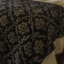

masked source image for example 0


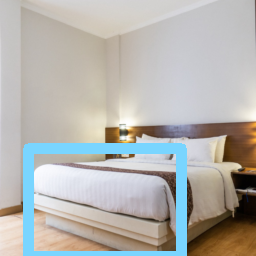

edited output for example 0


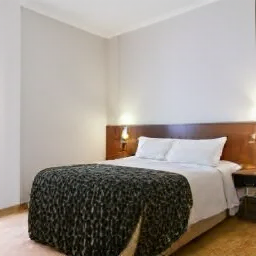

driver image for example 1


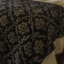

masked source image for example 1


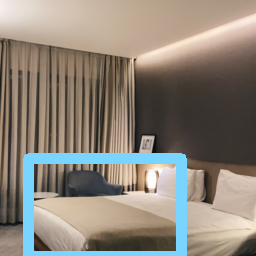

edited output for example 1


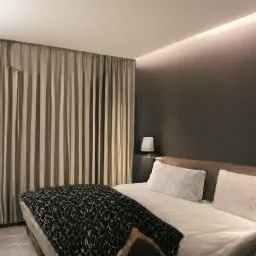

driver image for example 2


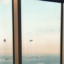

masked source image for example 2


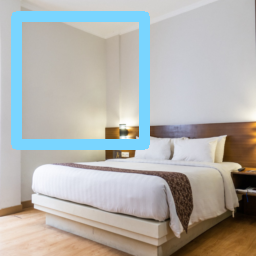

edited output for example 2


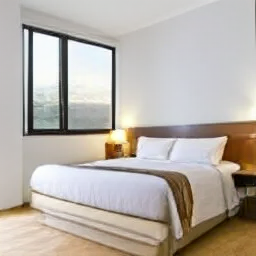

driver image for example 3


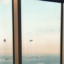

masked source image for example 3


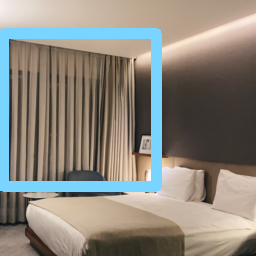

edited output for example 3


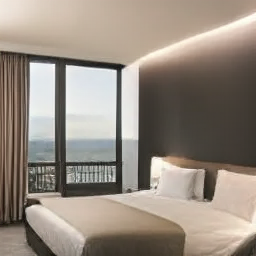

In [35]:
# ======================================
# run the model
# ======================================

images = model.log_images(batch,do_not_remake=True, only_deterministic=True)

# visualise the edits
images["samples_det"] = torch.clamp(images['samples_det'], -1., 1.).detach().cpu()
image = (images["samples_det"]+1.0)/2.0

for ind in range(len(examples)):
    example = examples[ind]
    
    sampled_image = image[ind].transpose(0,1).transpose(1,2).squeeze(-1).cpu().detach().numpy()
    sampled_image = (sampled_image*255).astype(np.uint8)
    
    # display all of the images
    print('driver image for example ' + str(ind))
    display.display(Image.fromarray(example['driver_image']))
    print('masked source image for example '+ str(ind))
    display.display(Image.fromarray(example['annotated_source_image']))
    print('edited output for example '+ str(ind))
    display.display(Image.fromarray(sampled_image))